In [14]:
# -*- coding: utf-8 -*-
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#    http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or
# implied.
# See the License for the specific language governing permissions and
# limitations under the License.
#

# Time-series forecasting with Deep Learning (PyTorch)

### Author: Matej Voľanský alias DC Wenders (2024)

Inspired by https://github.com/FIIT-IAU/IAU-course/blob/main/exercises/week-11/IAU_01_RNN-tf-keras.ipynb

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import STL
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset

# Matplotlib settings
%matplotlib inline
plt.style.use('ggplot')

# Import Seaborn for enhanced visualization
import seaborn as sns
sns.set(context='paper', style='whitegrid', color_codes=True)   
sns.set_palette(sns.color_palette(["#017b92", "#f97306", "#ff0000"]))  # ["green", "orange", "red"] 

# Function to determine the available computing device (GPU/CPU)
def decide_device():
  if (torch.cuda.is_available()): return "cuda"
  #if (torch.backends.mps.is_available()): return "mps"
  return "cpu"

## Data creation and preprocessing

Let's generate and visualize a synthetic time series dataset consisting of a combination of `sine` and `cosine` waves with added noise

(500, 1)


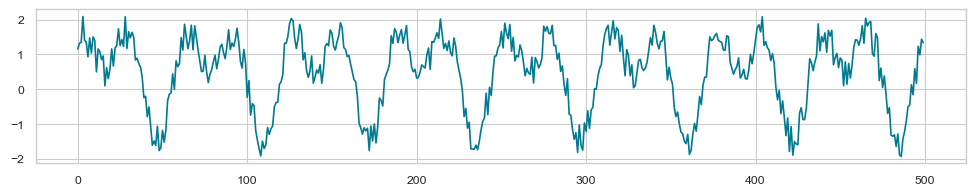

In [16]:
n = 500
x = np.arange(0, n, 1) 
# Generate a synthetic time series using sine and cosine functions 
# with added random noise to simulate real-world fluctuations
y = np.sin(16*np.pi*x/n) + np.cos(32*np.pi*x/n) + np.random.rand(n)
data_org = y.reshape(-1, 1)

print(data_org.shape)
plt.rcParams["figure.figsize"] = (12,2)
plt.plot(data_org)

## Data transformation

**The Augmented Dickey-Fuller (ADF)** test is a `statistical test` used to determine whether a time series is stationary (it has a constant mean and variance over time). Non-stationary data can lead to inaccurate predictions. A low p-value (<0.05) means the data is stationary, while a high value suggests it needs transformation before applying predictive models.

**Seasonal-Trend Decomposition (STL)** is a technique used to separate a time series into its trend, seasonality, and residual components. Removing the seasonal component can improve forecasting performance. In this case, STL helps extract the trend from our noisy time series, focus on the underlying long-term pattern making it easier to analyze and model 

STL separates time series into:
 - trend (long-term movement)
 - seasonality (repeating patterns)
 - residual (random noise)

	1. ADF: -4.472101743304876
	2. P-Value: 0.00022076894379943868
	3. Num Of Lags: 15


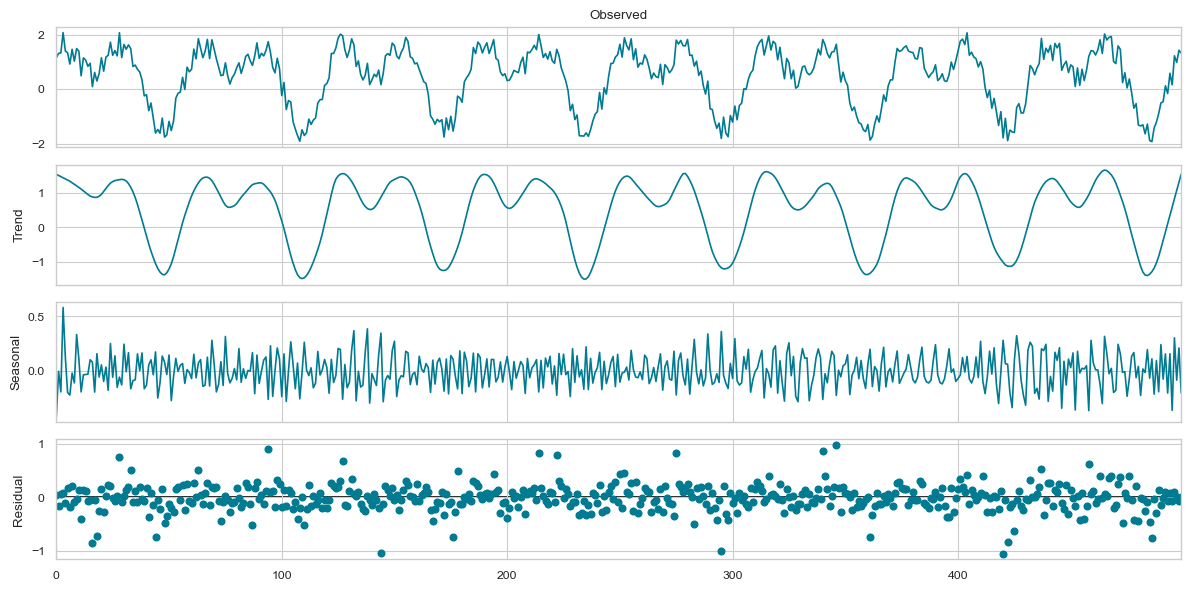

In [17]:
# Stationarity test
dftest = adfuller(data_org, autolag='AIC') # Perform ADF test to check for stationarity
print(f"\t1. ADF: {dftest[0]}")
print(f"\t2. P-Value: {dftest[1]}")
print(f"\t3. Num Of Lags: {dftest[2]}")

# Seasonal decomposition
result = STL(data_org, period=6, robust=True).fit() # Apply STL decomposition
plt.rcParams["figure.figsize"] = (12,6)
result.plot()
plt.show()

data_cleaned = result.trend.reshape(-1, 1) # Extract the trend and reshape to (n,1)

## Data normalization

We normalize the data to improve the stability and efficiency of model training, especially for **LSTMs**, which perform better with values in a `small range`.Additionally, normalization prevents large values from dominating smaller ones, ensuring the model treats all input data fairly. 

In [18]:
scaler = MinMaxScaler(feature_range=(0, 1)) # Scale data between 0 and 1
data_trans = scaler.fit_transform(data_cleaned)

## Data splitting

Let`s split the dataset into 80% training and 20% testing

In [19]:
train_size = int(len(data_trans) * 0.80)
test_size = len(data_trans) - train_size
train, test = data_trans[0:train_size, :], data_trans[train_size:len(data_trans), :]

## PyTorch Dataset

Transforming a sequential dataset into supervised learning format by creating input-output pairs. This means taking past values (look_back steps) as input and predicting the next value as output (target)

In [20]:
# Define the number of past time steps to use as input
look_back = 10

# Function to transform time series data into input-output pairs
def create_dataset(data, look_back):
    sequences = []  # List to store input sequences
    targets = [] # List to store corresponding target values (next value in sequence)

# Loop through the dataset to create sequences of length 'look_back'
    for i in range(len(data) - look_back):
        sequence = data[i:i + look_back]# Extract 'look_back' number of time steps
        target = data[i + look_back]# The next time step (prediction target)
        sequences.append(sequence)
        targets.append(target)


    sequences, targets = np.array(sequences), np.array(targets)
    return torch.tensor(sequences).float(), torch.tensor(targets).float()

# Create datasets for training and testing using the function
train_sequences, train_targets = create_dataset(train, look_back)
test_sequences, test_targets = create_dataset(test, look_back)

# Convert the sequences and targets into PyTorch datasets
train_dataset = TensorDataset(train_sequences, train_targets)
test_dataset = TensorDataset(test_sequences, test_targets)

# Create data loaders to facilitate batch processing during training and evaluation
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)  # Shuffle for randomness
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

## PyTorch model

Defining an LSTM-based neural network for time series forecasting

In [21]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
         # Define an LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        # Define a fully connected (Linear) layer to map LSTM output to final prediction
        self.linear = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        _, (h_n, _) = self.lstm(x)
        x = self.linear(h_n.squeeze(0))
        return x

model = LSTMModel(1, 5, 1)
# input_size=1: One feature per time step
# hidden_size=5: LSTM layer has 5 hidden units
# output_size=1: Model predicts a single value

optimizer = Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
# Determine the computation device (CPU or GPU)
device = torch.device(decide_device())
# Store the best model state
best_model_state = None

## Training loop

Training an LSTM model for 20 epoch. The best model state with the lowest loss is saved

In [22]:
def train(model, train_loader, criterion, optimizer):
    global best_model_state
    model.train()
    curr_loss = 200 # Initialize a high loss value to store the best model
    
    for epoch in range(20):
        for sequences, targets in train_loader: # Iterate over the training batches

            optimizer.zero_grad() # Reset gradients to avoid accumulation

             # Move input and target tensors to the selected device (CPU or GPU)
            sequences = sequences.to(device)
            targets = targets.to(device)

            # Forward pass: Get model predictions
            outputs = model(sequences)

             # Compute the loss between predicted and actual values
            loss = criterion(outputs, targets)

            # Backward pass: Compute gradients
            loss.backward()

            # Update model parameters
            optimizer.step()
            
         # Save the model if the current loss is the lowest so far
        if loss.item() < curr_loss:
            print("Found best model at epoch: ",epoch)
            curr_loss = loss.item()
            best_model_state = model.state_dict().copy()
            
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')

train(model, train_loader, criterion, optimizer)

Found best model at epoch:  0
Epoch 1, Loss: 0.04889734834432602
Found best model at epoch:  1
Epoch 2, Loss: 0.012176928110420704
Found best model at epoch:  2
Epoch 3, Loss: 0.0010067775147035718
Epoch 4, Loss: 0.003934931475669146
Found best model at epoch:  4
Epoch 5, Loss: 0.0005598354618996382
Epoch 6, Loss: 0.0024042336735874414
Found best model at epoch:  6
Epoch 7, Loss: 0.0003779690305236727
Found best model at epoch:  7
Epoch 8, Loss: 0.00019338187121320516
Epoch 9, Loss: 0.0007160312379710376
Epoch 10, Loss: 0.0037072531413286924
Found best model at epoch:  10
Epoch 11, Loss: 7.502433163608657e-06
Epoch 12, Loss: 0.0007683911826461554
Epoch 13, Loss: 0.0006150371627882123
Found best model at epoch:  13
Epoch 14, Loss: 1.178612023977621e-06
Epoch 15, Loss: 4.273349986760877e-06
Epoch 16, Loss: 0.000993011286482215
Epoch 17, Loss: 0.00022395473206415772
Epoch 18, Loss: 7.659939001314342e-05
Epoch 19, Loss: 1.0341687811887823e-05
Epoch 20, Loss: 1.9358583358553005e-06


## Evaluation function

Evaluating a trained LSTM model on a given dataset

In [23]:
def evaluate(model, loader):
    model.eval()
    predictions, actuals = [], []

     # Disable gradient computation (saves memory & speeds up evaluation)
    with torch.no_grad(): 
        for sequences, targets in loader:
            # Forward pass: generate predictions
            outputs = model(sequences)
            predictions.append(outputs.numpy())
            actuals.append(targets.numpy())
    return np.array(predictions), np.array(actuals)

trainPredict, trainY = evaluate(model, train_loader)
testPredict, testY = evaluate(model, test_loader)

## Rescaling predictions

Before training, time series data was scaled. After making predictions, the results are still in the scaled form and need to be converted back to their real values

In [24]:
trainPredict = scaler.inverse_transform(trainPredict.reshape(-1, 1))
testPredict = scaler.inverse_transform(testPredict.reshape(-1, 1))
trainY = scaler.inverse_transform(trainY.reshape(-1, 1))
testY = scaler.inverse_transform(testY.reshape(-1, 1))

## Calculate RMSE

RMSE represents how much the model's predictions deviate from actual values

In [25]:
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.2f RMSE' % (testScore))
torch.save(best_model_state, 'lstm_model.pt')

Train Score: 0.04 RMSE
Test Score: 0.03 RMSE


## Plotting

 Plotting the actual time series data, the true values of the test set, and the model’s predictions on the test set. It ensures that predictions align correctly with the time series structure

C:\Temp\ipykernel_9888\3720656236.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


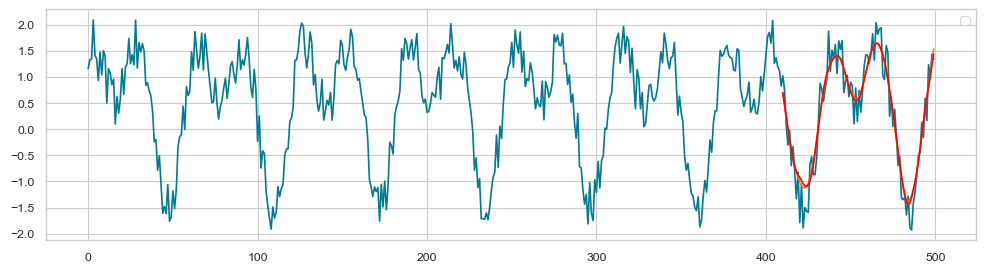

In [26]:
begin = train_size + look_back
end = begin + len(testPredict)

testYPlot = np.empty_like(data_org)
testYPlot[:, :] = np.nan # Fill it with NaNs so that only the test values appear
testYPlot[begin:end, :] = testY # Assign actual test values in the correct time rang

testPredictPlot = np.empty_like(data_org)
testPredictPlot[:, :] = np.nan # Fill it with NaNs so that only predictions appear
testPredictPlot[begin:end, :] = testPredict # Assign predicted values in the test range

# plot baseline and predictions
plt.rcParams["figure.figsize"] = (12,3)
plt.plot(data_org) # blue line -full original time series 
plt.plot(testYPlot) # orange line - actual values from the test set
plt.plot(testPredictPlot) # red line - model’s predictions 
plt.show()